In [1]:
import pandas as pd

C:\Users\Mayur\AppData\Local\Temp\ipykernel_13900\4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
lie_data = pd.read_csv('.\previous-MLcode\lie_dataset.csv')
lie_data.head()

,lipsx,lipsy,left_browx,left_browy,right_browx,right_browy,body0x,body0y,body1x,body1y,...,body7y,face0x,face0y,face1x,face1y,face2x,face2y,face3x,face3y,TRUTH
0,-0.001107,0.031804,-0.053075,-0.033591,0.060648,-0.029370,0.244749,-0.003385,-0.244749,0.003385,...,0.544281,0.008663,-0.040341,-0.004295,0.063091,-0.080905,0.017946,0.079827,0.023363,1
1,-0.001794,0.030796,-0.052959,-0.032074,0.059244,-0.029025,0.246057,-0.003136,-0.246057,0.003136,...,0.544409,0.007592,-0.037885,-0.004266,0.061061,-0.079106,0.019367,0.077311,0.023393,1
2,-0.002718,0.031074,-0.054027,-0.032401,0.058203,-0.028548,0.246974,-0.002954,-0.246974,0.002954,...,0.545489,0.006395,-0.037179,-0.006021,0.060508,-0.081213,0.019012,0.075062,0.023403,1
3,-0.002734,0.031018,-0.053086,-0.032754,0.059224,-0.028536,0.247235,-0.002925,-0.247235,0.002925,...,0.545792,0.007735,-0.037539,-0.006494,0.060074,-0.080609,0.018408,0.075682,0.023359,1
4,-0.002798,0.030957,-0.052412,-0.032349,0.058886,-0.028198,0.247395,-0.002847,-0.247395,0.002847,...,0.545749,0.007852,-0.037106,-0.006559,0.060057,-0.080242,0.018465,0.075385,0.023527,1


In [3]:
X = lie_data.copy()
y = X.pop("TRUTH")

input_shape = X.shape[1]

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.6)

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[input_shape]),
    layers.Dropout(0.4),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid'),
])

In [8]:
model.compile(
    optimizer = "adam",
    loss="binary_crossentropy",
    metrics=['binary_accuracy']
)

Epoch 1/1024
5/5 [==============================] - 0s 26ms/step - loss: 0.4256 - binary_accuracy: 0.8307 - val_loss: 0.4411 - val_binary_accuracy: 0.8095
Epoch 2/1024
5/5 [==============================] - 0s 14ms/step - loss: 0.4355 - binary_accuracy: 0.7778 - val_loss: 0.4587 - val_binary_accuracy: 0.8016
Epoch 3/1024
5/5 [==============================] - 0s 13ms/step - loss: 0.4502 - binary_accuracy: 0.7937 - val_loss: 0.4505 - val_binary_accuracy: 0.7778
Epoch 4/1024
5/5 [==============================] - 0s 12ms/step - loss: 0.4288 - binary_accuracy: 0.8042 - val_loss: 0.4480 - val_binary_accuracy: 0.8095
Epoch 5/1024
5/5 [==============================] - 0s 14ms/step - loss: 0.4565 - binary_accuracy: 0.7989 - val_loss: 0.4606 - val_binary_accuracy: 0.8016
Epoch 6/1024
5/5 [==============================] - 0s 12ms/step - loss: 0.4415 - binary_accuracy: 0.7831 - val_loss: 0.4504 - val_binary_accuracy: 0.8095
Epoch 7/1024
5/5 [==============================] - 0s 13ms/step - los

<Axes: title={'center': 'Accuracy'}>

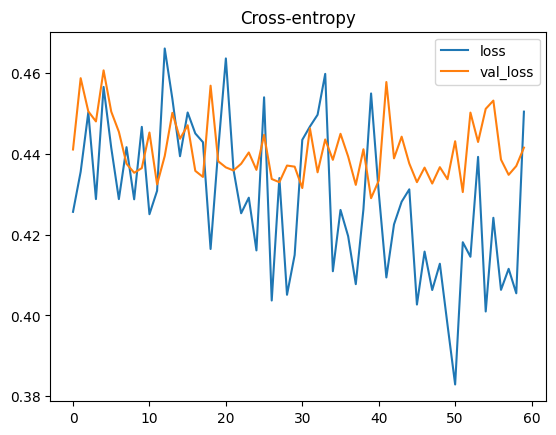

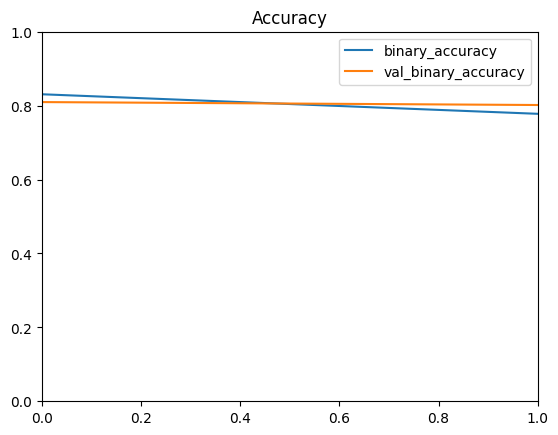

In [12]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.0000000001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=40,
    epochs=1024,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy", xlim=[0,1], ylim=[0,1])